Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

In Lesson 5 of *Anomaly Detection*, we learned that high dimensional data introduces additional complications to anomaly detection ("the curse of dimensionality"). We also discussed two approaches to anomaly detection in high dimensions: the subspace method with feature bagging and isolation forests.

Here will use both the subspace method and isolation forests to detect anomalies in high dimensional simulated datasets.


# Learning Outcomes

You should walk away from this Python tutorial with:
1. An understanding of the challenges of anomaly detection with high dimensional data
2. Some practical experience with the subspace method and feature bagging
3. Some practical experience with isolation forests 

# Imports

In [1]:
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest

# Python and library versions

In [2]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("scipy", scipy.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)] 

library    version
------------------
matplotlib  3.1.0
numpy       1.16.4
pandas      0.24.2
scipy       1.2.1


---

# Section 1: The subspace method with feature bagging

In this section, we are going to use simulated data to illustrate the subspace method with feature bagging. 

Our approach will follow an early publication in anomaly detection using the subspace method with feature bagging (A. Lazarevic and V. Kumar. Feature Bagging for Outlier Detection. ACM KDD Conference, 2005). It is 
available here: http://neuro.bstu.by/ai/To-dom/My_research/Papers-0/For-research/D-mining/Anomaly-D/KDD-cup-99/p157.pdf

We will proceed as follows:

1. Create the simulated data
2. Perform anomaly detection with the subspace method/feature bagging
3. Score the results
4. Analyze the output using a confusion matrix

### Data

We start by creating the data, which will be a combination of normal points and anomalies for a total of 5100 points. The 5000 normal points are generated from a 5D Gaussian distribution where we specify the mean in each dimension as well as the covariance matrix.  The anomalies are 100 points that are far away from the normal points in the same 5D space (the relevant features). To explore the effects of feature bagging, an additional 5D of noise (irrelevant features) are added to all data points.



First, we will generate the 5000 normal data points

In [3]:
np.random.seed(20) # include a seed for reproducibility

# generate the normal data using number of points, 
# number of relevant features, mean and standard deviation
norm_pts = 5000
norm_dim = 5
norm_mean = 0.0
norm_stdev = 0.5
norm_data = np.random.normal(norm_mean, norm_stdev, 
                             (norm_pts, norm_dim))

# Note:
#
# Do not confuse the two uses of 'normal'
# The 'normal' in np.random.multivariate_normal refers 
# to a Gaussian distribution and is not related in general 
# to normal vs. anomaly 


Next, we generate the anomalous data. We will do this in two steps:

A. Generate a Gaussian distrubution of points

B. Transform this distribution into a ring around the normal points.

In [4]:
# Generate Gaussian distribution for preliminary anomaly data
# using number of points, number of relevant features, 
# mean and standard deviation
anom_pts = 100
anom_dim = 5
anom_mean = 0.0
anom_stdev = 0.5
anom_data_prelim = np.random.normal(anom_mean, anom_stdev, 
                             (anom_pts, anom_dim))

In [5]:
# Transform into ring distribution for final anomaly data
def transform_to_ring(data, radius, spread):
    """
    Transforms the data provided into a ring distribution.
    ---
    Inputs: data (the data to be transformed, np.array),
    radius (radius of ring, float)
    spread (spread of data about radius, float)
    Outputs: transformed_data (np.array)
    """
    transformed_data_list = []
    for item in data:
        z = np.array(item) # in case data is provided as list
        transformed_data_list.append(z*spread 
                                     + radius*z / np.linalg.norm(z))
        transformed_data = np.array(transformed_data_list)
    return transformed_data



In [6]:
anom_data = transform_to_ring(anom_data_prelim, 2.0, 1.0)

Plot the data and color code normal vs. anomaly

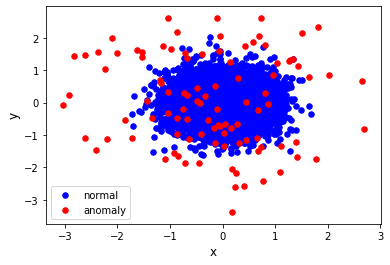

In [7]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.scatter(norm_data[:,0], norm_data[:,1], s=30, c='b', marker="o", 
            label='normal')
ax1.scatter(anom_data[:,0], anom_data[:,1], s=30, c='r', marker="o", 
            label='anomaly')
plt.legend(loc='best');
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

As we are plotting a 5D distribution in 2D, it is hard to see the ring nature of the anomaly data. 

**Question**: How could we quickly check that our ring transformation is working?

**Answer**: Look at the anomalies in 2D. Set the parameter *anom_dim* to 2 and explore what happens when you change *radius* and *spread*.

In [8]:
# Combine the data into one array for later use
combined_data = np.concatenate((norm_data, anom_data), axis=0)
combined_data.shape

(5100, 5)

In [9]:
# Create noise for normal data (1) and anomalies (2)
# using number of irrelevant features, 
# mean and standard deviation
noise_dim = 5
noise_mean = 0
noise_stdev = 4
noise_norm = np.random.normal(noise_mean, noise_stdev, 
                                    (norm_pts, noise_dim))
noise_anom = np.random.normal(noise_mean, noise_stdev, 
                                    (anom_pts, noise_dim ))


In [10]:
# Add noise to normal data and anomalies 
# to create full data (all features)
norm_data_full = np.concatenate((norm_data, noise_norm), axis=1)
anom_data_full = np.concatenate((anom_data, noise_anom), axis=1)

In [11]:
# Aggregate normal data and anomalies for later use
all_data = np.concatenate((norm_data_full, anom_data_full), axis=0)

### Anomaly detection with feature bagging

A reminder of how feature bagging works in $d$ dimensions:
    
1. Select an integer $m$ at random from $\lfloor{d/2}\rfloor$ to $d-1$
2. For each iteration, select $m$ features at random without replacement from the full dataset producing an $m$-dimensional subset 
3. Apply the anomaly detection algorithm to the subset to score each data point
4. Combine scores from the different iterations to get an overall result for each point


Start by defining a function to implement steps 1 and 2.

In [12]:
def feature_bagging(data):
    """
    Selects subspace data using feature bagging.
   
    Args: 
        data: the full data to be sampled (np.array)
        
    Returns: 
        subspace_data: the subspace data (np.array)
    """
    # Find the size of the full dimensional space
    full_dim = data.shape[1]
    # select size of subspace
    size_subspace = np.random.randint(full_dim // 2, full_dim - 1)
    # select features without replacement 
    subspace_index = np.random.choice(full_dim, size_subspace, 
                                      replace=False)
    # select subspace data 
    # Originally, features are data columns
    # Transponse to select features as rows (easier)
    # and then transponse back to restore features as columns
    subspace_data = (data.T[sorted(subspace_index),:]).T
    return subspace_data

Now carry out anomaly detection on subspace data (step 3). We will use the local outlier factor (LOF) approach discussed in Lesson 4. LOF was also used by Lazarevic and Kumar because it returns appropriately normalized scores that account for feature subspaces of different dimensions. 

To combine the scores from each iteration (step 4), we will use the cumulative-sum approach (see Lesson 05 lecture).

In [13]:
def anomaly_subspace_method(data, repeat):
    """
    Carries out anomaly detection using feature bagging.
    Uses Local Outlier Factor (LOF) for anomaly detection.
    Uses cumulative-sum approach to combine anomaly detection scores. 
    from each iteration
    
    Args: 
        data: the full data to be sampled (np.array)
        repeat: number of iterations for feature bagging (int)
    Returns:
        final_scores: the anomaly score of each point in the data (list)
    """
    final_scores = np.zeros(len(data))
    for i in range(repeat):
        subspace_data = feature_bagging(data)
        clf = LocalOutlierFactor(n_neighbors=20, metric='manhattan')
        y_pred = clf.fit_predict(subspace_data)
        X_scores = clf.negative_outlier_factor_
        final_scores += X_scores
    return final_scores
        

**Note**—we use the *negative_outlier_factor_* scoring convention of *sklearn*:

Inliers tend to have a *negative_outlier_factor_* close to -1.
<br>outliers tend to have a large negative number.

See also Lesson 04 and http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

Now it's time to analyze the data. We'll repeat the feature bagging 50 times.

In [14]:
cumulative_scores = anomaly_subspace_method(all_data, 10)

In [15]:
cumulative_scores.shape

(5100,)

We know that the first 5000 points are normal data and the next 100 are anomalies. Therefore we expect that the scores at the beginning of *cumulative_scores* should be less negative than those at the end.

In [16]:
print(cumulative_scores[0:20])

[-10.42822032 -10.11430337  -9.94264351  -9.97740891 -11.35658359
 -10.65692172 -10.59557416 -11.89593756 -10.3129885  -10.14233905
 -12.02322703 -10.52378682 -10.10541638 -10.96957967 -10.63905103
 -10.36021459  -9.92217649 -10.67933135 -10.98069907 -11.39922243]


In [17]:
print(cumulative_scores[5080:5100])

[-14.85215851 -14.21291428 -15.21692821 -15.68583487 -16.28738734
 -15.99495715 -16.38737843 -14.46308237 -14.99386485 -16.59273306
 -11.95628822 -15.18960334 -15.72579168 -14.53332571 -22.4328569
 -15.98863141 -14.32595071 -14.94775829 -15.18901059 -14.30024492]


Looks reasonable, but with so many data points, we must go beyond simple inspections and do some statistical analysis.

Since the predicted anomalies will have the lowest scores, we sort the scores from low to high and return the index of each corresponding data point.

In [18]:
ranking_by_index = np.argsort(cumulative_scores)

Again, let's do a quick check. 

In [19]:
print(ranking_by_index[0:20])

[5094 5028 5067 5079 5052 5054 5062 5077 5050 5089 5006 5020 1128 5009
 5053 5086 5084 5048 5016 5042]


Most of the 20 points with the lowest scores have indices that are 5000 or greater. Encouraging!

To create a confusion matrix, we will create two arrays: one with the true labels for each point and the other with the predicted labels. We will use a 1 for the anomalies and a 0 for the normal points.

In [20]:
# Create labels based on known data
# We know that the first *norm_pts* are normal data (0)
# and the next *anom_pts* are anomalies (1)
label_true = [0]*norm_pts
for i in range(anom_pts):
        label_true.append(1)


We get the predicted labels using *ranking_by_index*. Since we know that we have 100 anomalies , we will label the first 100 lowest scores as anomalies and the rest as normal data. (To be more general, we will use the parameter *anom_pts* instead of a number).

In [21]:
label_pred = [0]*len(all_data)
for index, item in enumerate(ranking_by_index):
    label_pred[item] = 1
    if index == anom_pts:
        # We stop once we have label *anom_pts* points 
        break

Now that we have our labels, we can construct a confusion matrix. One way to do so is with pandas dataframes.

In [22]:
label_true_series = pd.Series(label_true, name='True')
label_pred_series = pd.Series(label_pred, name='Predicted')
df_confusion_matrix = pd.crosstab(label_true_series, label_pred_series)
df_confusion_matrix

Predicted,0,1
True,,
0,4985,15
1,14,86


We correctly found 86 out of 100 anomalies and also found 4985 out of 5000 normal data points. 

Alternatively, we can use scikit-learn. 

In [23]:
# See Imports section above
confusion_matrix(label_true, label_pred)

array([[4985,   15],
       [  14,   86]], dtype=int64)

The advantage of scikit-learn is that is has many useful functions to evaluate different statistical measures of performance. For example, we can calculate the accuracy, which is the proportion of true results (both true positives and true negatives) out of the total number of points analyzed.

In [24]:
accuracy_score(label_true, label_pred)

0.994313725490196

For additional statistical measures, see http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

It looks like we have created superb anomaly detector, but before we celebrate, we should remember that we had significant help: we included the number of anomalies (but not their identities) in the scoring procedure. If we didn't know how many anomalies we had, the anomaly detection would become more challenging. 

(And see Lesson 06 for a discussion of the limitations of accuracy as a metric for anomaly detection algorithms.)

Also, there were several parameters we had to choose: *repeat* for the number of times to carry or feature bagging;  *n_neighbors* and *metric* for the LOF evaluation. There are rules of thumb for chooing these paramters, but often exploratory work is need to find the appropriate values for the problem at hand. 

# Section 2: Isolation forests


In this section, we are going to examine isolation forests using the same simulated data we analyzed with the subspace method.

We will proceed just as we did with the subspace method:

1. Create the simulated data—**done already**
2. Perform anomaly detection with the isolation forest algorithm
3. Score the results
4. Analyze the output using a confusion matrix

### Anomaly detection with isolation forest

A reminder of how isolation forest works: 


<li> It is an ensemble method: an isolation forest is a combination of isolation trees.</li>

<li> To create an isolation tree, a feature is chosen at random and the data is repeated divided with axis-parallel cuts at randomly chosen positions.</li>

<li> This process is repeated with the goal to divide the data into nodes with fewer and fewer points until a singleton node containing one point is reached (the “leaf” of the tree).</li>

<li> We expect the tree branches containing anomalies to be less deep than those for normal points, because anomalies are located in sparse regions.</li>

<li>Therefore, the depth of the branch can be used to score the point in the leaf. </li>
    
<li>This process is repeated for a predetermined number of trees to calculate a mean anomaly score.</li>  

<li>This final score is then compared with a threshold to label the point as a normal point or an anomaly.</li>


More details are available in the publications of the original authors of this technique (F. L. Kai, M. Ting and Z.-H. Zhou):
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf
 

We will use the sklearn implementation of the isolation forest, which includes the detection algorithm as well as the scoring procedure (steps 2 and 3 in the process outlined in the previous subsection):

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

This implementation uses a different scoring convention than the original publication by Kai, Ting and Zhou. In the sklearn version, negative scores represent anomalies, positive scores represent normal data. (For a given point, the more negative the score, the more of an anomaly it is.)

There are several key parameters for IsolationForest, the sklearn algorithm. If a training dataset is available, this dataset can be used to tune these parameters. In our case, we don't have a training dataset, so we will use reasonable (default) values as discussed below.

First let's create our forest.

In [25]:
isolation_forest = IsolationForest(n_estimators=100, max_samples=256, 
                                   contamination=0.01961, max_features=10)


The parameters explained:
    
1. *n_estimators*: the number of isolation trees in the forest. The default value is 100.

2. *max_samples*: this is the maximum number of samples drawn to construct each tree. Sklearn offers several choices for this parameter. Kai, Ting and Zhou find that 256 is "generally is enough to
perform anomaly detection across a wide range of data."

3. *max_features*: the number of features drawn to construct each tree. Here we use the full dimensionality of our dataset (10). Using a smaller value would introduce feature bagging into the tree.

4. *contamination*: the fraction of points that are anomalies. Just as we did for the subspace method, we will use this number when labeling the anomalies. The number given is  (*anom_pts*)/(*anom_pts* + *norm_pts*) = 100/5100.

Now that we've created the forest, we can fit our data and score the points. To do this properly, we should construct the tree with a training dataset and then apply this tree to the test data. You will do so in Exercise 2 below. 

For now, we're going to take a simplified approach and fit the tree and score the points using the same data. This is a cavalier approach to isolation forest that can lead to biased results, but it makes for a fairer comparison with the subspace method (where there is no train/test  split).

In [26]:
isolation_forest.fit(all_data)
anomaly_score = isolation_forest.decision_function(all_data)

Just as with the subspace method, we know that the first 5000 points are normal data and the next 100 are anomalies. Therefore, we expect that the scores at the beginning of *anomaly_scores* should be positive and those at the end negative.

In [27]:
print(anomaly_score[0:20])

[0.11709204 0.1128159  0.13177338 0.13714886 0.07200826 0.08519496
 0.04784857 0.05821061 0.06748824 0.11306076 0.04558373 0.09645274
 0.11755097 0.06819345 0.06142693 0.08882511 0.15169793 0.09186298
 0.07999592 0.05882143]


In [28]:
print(anomaly_score[5080:5100])

[-0.04777688 -0.04418608 -0.01611999 -0.06212357 -0.07933462 -0.02386272
  0.00986377  0.01580545  0.04366959 -0.08361305  0.02765042 -0.02287911
  0.01593167  0.00914116 -0.09425714  0.00650565  0.02878218  0.01659102
  0.00461355  0.05373863]


We see some positive scores at the end, but it would a lot to ask for our isolation forest to be perfect. What does *IsolationForest* predict the last 100 points to be?

**Note**: *IsolationForest* labels anomalies with -1 and normal points with +1.

In [29]:
pred_forest = isolation_forest.predict(all_data)

In [30]:
print(pred_forest[5000:5100])

[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1
  1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1
  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1
  1  1  1  1]


We are happy to see mainly -1, but we should calculate precise statistics. To make a clear comparison with our subspace method results, we will convert *pred_forest* to the labeling convention we used previously: anomalies are +1 and normal data points are 0.


In [31]:
label_pred_forest = pred_forest
# normal data label switched from 1 to 0
label_pred_forest [label_pred_forest > 0] = 0 
# anomaly label switched from -1 to 1
label_pred_forest [label_pred_forest < 0] = 1 

In [32]:
confusion_matrix(label_true, label_pred_forest)

array([[4961,   39],
       [  39,   61]], dtype=int64)

In [33]:
accuracy_score(label_true, label_pred_forest)

0.9847058823529412

When we look at the confusion matrix, we can see that have fewer true positive results than with the subspace method. Nevertheless, it is a popular method because of its speed (low computation complexity).

### Exercise #1

This exercise refers to Section 1 (subspace method with feature bagging). 

We are going to analyze the data without any feature bagging and check whether the claim we made in lectures is correct: feature bagging improves anomaly detection

A. Modify *anomaly_subspace_method* to carry out anomaly detection on the full data without any feature bagging.

B. Determine the confusion matrix.

C. How do the results compare with the subspace method? 


### Solution #1

In [34]:
# YOUR CODE HERE

### Exercise #2

This exercise refers to Section 2 (isolation forests).

A. Create a training dataset. It should have the same features as *all_data* except it should different points and be one fifth the size (20 anomalies and 1000 normal points).


B. Train the isolation forest on this dataset and then test the trained forest on *all_data*.

C. Compare the results for the confusion matrix for the one you got without the test/train split. Discuss any differences.


### Solution #2

In [35]:
# YOUR CODE HERE

# Summary

In this assignment you should have learned: 

1. How to use the subspace method and feature bagging
2. How to use isolation forests 

Congratulations! This concludes the lesson.

In [36]:
print('end')

end
